In [85]:
import numpy as np
import pandas as pd
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import torch_geometric.nn as gnn
import torch.nn.functional as F

## CiteSeer overview

In [86]:
dataset = Planetoid(root='../data/', name='CiteSeer')
data = dataset[0]
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [124]:
dataset.get_summary()

Planetoid (#graphs=1):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     3327 |     9104 |
| std        |      nan |      nan |
| min        |     3327 |     9104 |
| quantile25 |     3327 |     9104 |
| median     |     3327 |     9104 |
| quantile75 |     3327 |     9104 |
| max        |     3327 |     9104 |
+------------+----------+----------+

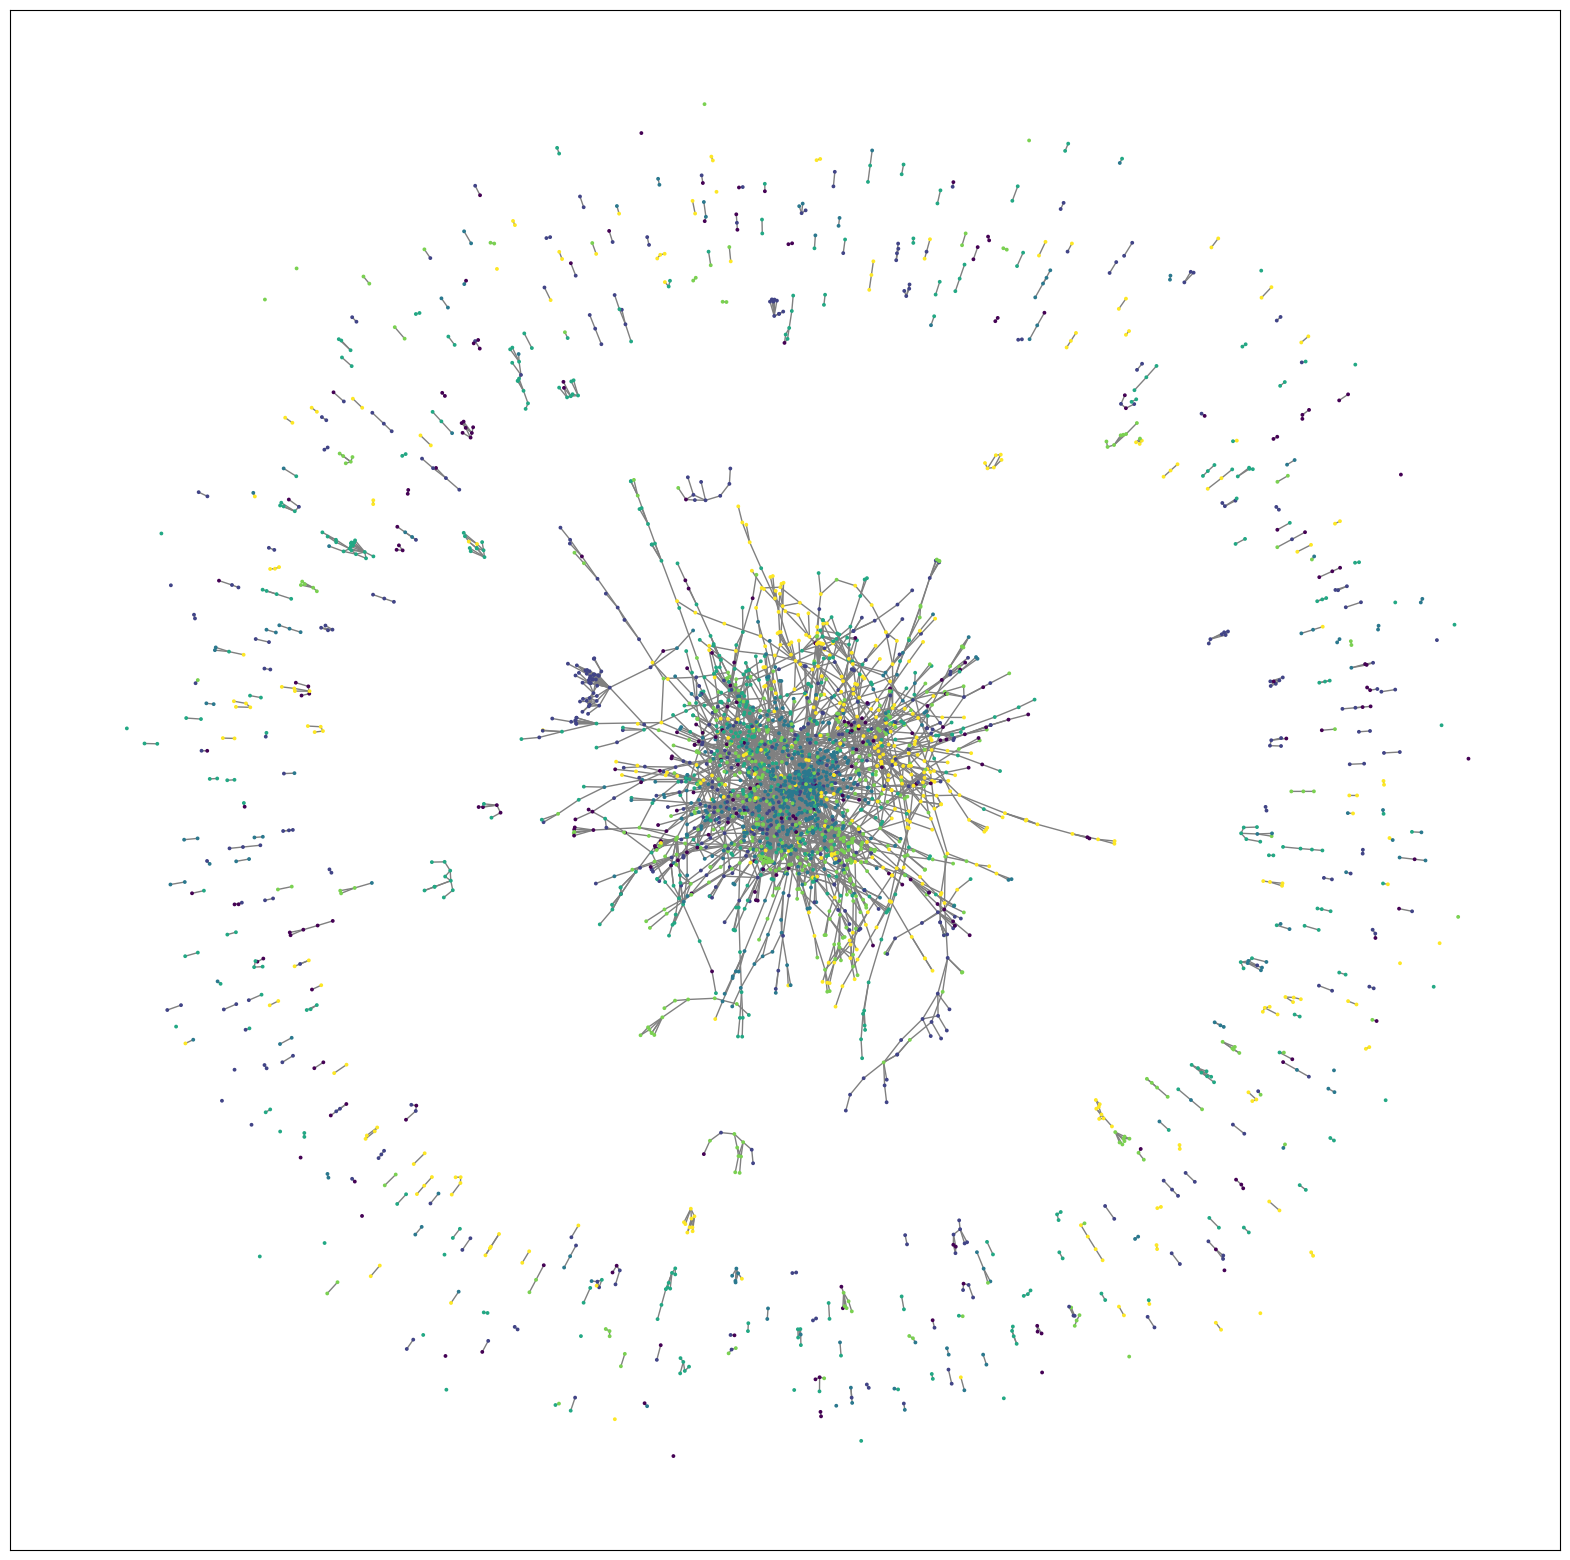

In [126]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(20, 20))
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=2010),
    node_size=3,
    node_color=data.y,
    edge_color='grey',
    with_labels=False
)

Text(0.5, 0, 'Count')

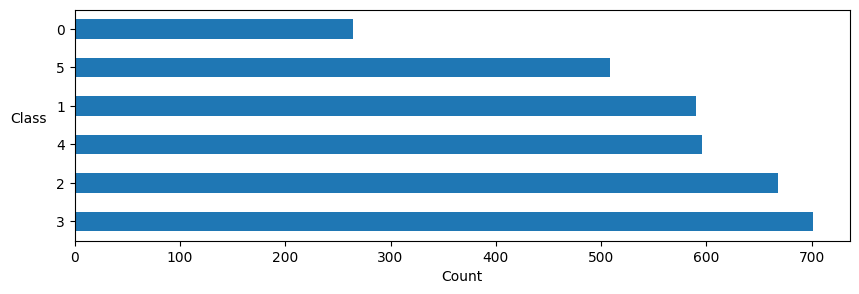

In [87]:
pd.Series(data.y).value_counts(sort=True).plot(kind='barh', figsize=(10, 3))
plt.ylabel('Class', rotation=0, labelpad=20)
plt.xlabel('Count')

In [88]:
print(f'{dataset.num_classes=}\n{dataset.num_features=}\n{data.num_nodes=}\
      \n{data.is_directed()=}\n{data.has_isolated_nodes()=}')

dataset.num_classes=6
dataset.num_features=3703
data.num_nodes=3327      
data.is_directed()=False
data.has_isolated_nodes()=True


In [89]:
not_isolated = pd.Series(data.edge_index[0]).unique().size
isolated_nodes_count = data.num_nodes - not_isolated
print(f'{isolated_nodes_count=}')

isolated_nodes_count=48


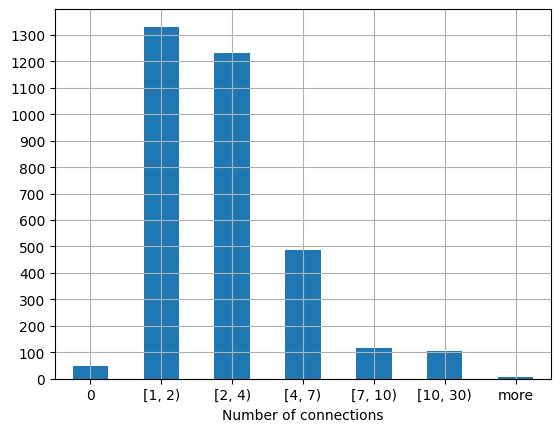

In [90]:
def to_categorical(el):
    quantiles = [1, 2, 4, 7, 10, 30, 60]
    for i in range(len(quantiles) - 1):
        if (el < quantiles[i]):
            return f'[{quantiles[i-1]}, {quantiles[i]})'
    return 'more'

connections = pd.Series(data.edge_index[0]).value_counts().apply(to_categorical)
connections = pd.concat([
    pd.Series({'0': isolated_nodes_count}),
    connections.value_counts()
])

connections.plot(kind='bar', grid=True)
plt.xticks(rotation=0);
plt.xlabel('Number of connections')
plt.yticks(np.arange(0, 1400, 100));

## Implementing a Graph Convolutional Network (GCN)

### Defining a model

In [91]:
class GCN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gcn1 = gnn.GCNConv(input_size, hidden_size)
        self.gcn2 = gnn.GCNConv(hidden_size, output_size)

    def forward(self, x, edge_index):
        out = F.dropout(x, p=0.5, training=self.training)
        out = self.gcn1(out, edge_index).relu()
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.gcn2(out, edge_index)
        return F.log_softmax(out, dim=1)
    
    def train(self, data, train_mask, val_mask, optimizer, crit, num_epochs, display_freq=None):
        
        losses, train_accuracies, val_accuracies = [], [], []
        self.training = True
        
        for epoch in range(num_epochs):
            optimizer.zero_grad()

            outputs = self(data.x, data.edge_index)
            y_pred = outputs.argmax(dim=1)

            loss = crit(outputs[train_mask], data.y[train_mask])
            train_acc = self.__accuracy__(y_pred[train_mask], data.y[train_mask])
            val_acc = self.__accuracy__(y_pred[val_mask], data.y[val_mask])

            loss.backward()
            optimizer.step()

            losses.append(loss)    
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            if display_freq and (epoch + 1) % display_freq == 0:
                print('Epoch %d: loss: %.2f, train_acc: %.2f%%, val_acc: %.2f%%' %\
                    (epoch + 1, loss, train_acc*100, val_acc*100))
                
        return losses, train_accuracies, val_accuracies
        
    def __accuracy__(self, y_pred, y):
        return (y_pred == y).sum() / len(y)
    
GCN(dataset.num_features, 16, dataset.num_classes)

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)

### Training

In [106]:
model = GCN(dataset.num_features, 16, dataset.num_classes)
crit = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=5e-4)
train_mask = dataset.train_mask
val_mask = dataset.val_mask

model.cuda()
crit.cuda()
data.cuda()
train_mask.cuda()
val_mask.cuda()

losses, train_accuracies, val_accuracies = model.train(
    data, train_mask, val_mask,
    optimizer, crit,
    num_epochs=300, display_freq=10
)

Epoch 10: loss: 0.61, train_acc: 86.67%, val_acc: 56.00%
Epoch 20: loss: 0.18, train_acc: 97.50%, val_acc: 54.40%
Epoch 30: loss: 0.10, train_acc: 97.50%, val_acc: 57.80%
Epoch 40: loss: 0.09, train_acc: 98.33%, val_acc: 60.80%
Epoch 50: loss: 0.05, train_acc: 100.00%, val_acc: 55.80%
Epoch 60: loss: 0.06, train_acc: 98.33%, val_acc: 61.00%
Epoch 70: loss: 0.06, train_acc: 99.17%, val_acc: 60.20%
Epoch 80: loss: 0.05, train_acc: 99.17%, val_acc: 59.80%
Epoch 90: loss: 0.07, train_acc: 98.33%, val_acc: 60.40%
Epoch 100: loss: 0.04, train_acc: 99.17%, val_acc: 60.40%
Epoch 110: loss: 0.05, train_acc: 100.00%, val_acc: 57.40%
Epoch 120: loss: 0.06, train_acc: 99.17%, val_acc: 58.00%
Epoch 130: loss: 0.09, train_acc: 95.83%, val_acc: 59.40%
Epoch 140: loss: 0.05, train_acc: 97.50%, val_acc: 59.00%
Epoch 150: loss: 0.04, train_acc: 99.17%, val_acc: 60.20%
Epoch 160: loss: 0.05, train_acc: 99.17%, val_acc: 60.40%
Epoch 170: loss: 0.04, train_acc: 99.17%, val_acc: 60.00%
Epoch 180: loss: 0.05

### Test accuracy

In [107]:
model.training = False
out = model(data.x, data.edge_index)
y_pred = np.argmax(out.detach().cpu(), axis=1)
model.cpu()
crit.cpu()
data.cpu()
train_mask.cpu()
val_mask.cpu()
(y_pred[dataset.test_mask] == data.y[dataset.test_mask]).sum() / len(data.y[dataset.test_mask])

tensor(0.6760)

### Visualization

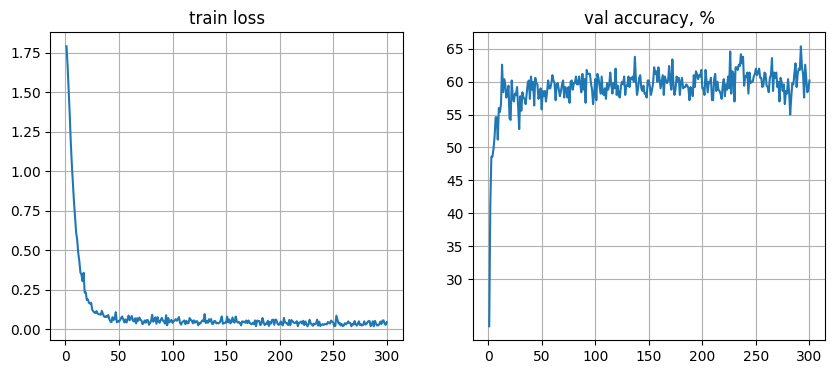

In [119]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
ax.set_title('train loss')
ax.plot(range(1, 300+1), torch.tensor(losses).cpu())
ax.grid(visible=True)

ax = plt.subplot(1, 2, 2)
ax.set_title('val accuracy, %')
ax.plot(range(1, 300+1), torch.tensor(val_accuracies).cpu()*100)
ax.set_yticks(np.arange(30, 66, 5));
ax.grid(visible=True)

## Implementing a Graph Attention Network (GAT)

### Defining a model

In [128]:
class GAT(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, heads=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.gat1 = gnn.GATv2Conv(input_size, hidden_size, heads=heads)
        self.gat2 = gnn.GATv2Conv(hidden_size * heads, output_size, heads=heads)

    def forward(self, x, edge_index):
        out = F.dropout(x, p=0.5, training=self.training)
        out = self.gat1(out, edge_index).relu()
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.gat2(out, edge_index)
        return F.log_softmax(out, dim=1)
    
    def train(self, data, train_mask, val_mask, optimizer, crit, num_epochs, display_freq=None):
        
        losses, train_accuracies, val_accuracies = [], [], []
        self.training = True
        
        for epoch in range(num_epochs):
            optimizer.zero_grad()

            outputs = self(data.x, data.edge_index)
            y_pred = outputs.argmax(dim=1)

            loss = crit(outputs[train_mask], data.y[train_mask])
            train_acc = self.__accuracy__(y_pred[train_mask], data.y[train_mask])
            val_acc = self.__accuracy__(y_pred[val_mask], data.y[val_mask])

            loss.backward()
            optimizer.step()

            losses.append(loss)    
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            if display_freq and (epoch + 1) % display_freq == 0:
                print('Epoch %d: loss: %.2f, train_acc: %.2f%%, val_acc: %.2f%%' %\
                    (epoch + 1, loss, train_acc*100, val_acc*100))
                
        return losses, train_accuracies, val_accuracies
        
    def __accuracy__(self, y_pred, y):
        return (y_pred == y).sum() / len(y)
    
GAT(dataset.num_features, 16, dataset.num_classes, heads=8)

GAT(
  (gat1): GATv2Conv(3703, 16, heads=8)
  (gat2): GATv2Conv(128, 6, heads=8)
)

### Training

In [129]:
model = GAT(dataset.num_features, 16, dataset.num_classes, heads=8)
crit = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=5e-4)
train_mask = dataset.train_mask
val_mask = dataset.val_mask

model.cuda()
crit.cuda()
data.cuda()
train_mask.cuda()
val_mask.cuda()

losses, train_accuracies, val_accuracies = model.train(
    data, train_mask, val_mask,
    optimizer, crit,
    num_epochs=300, display_freq=10
)

Epoch 10: loss: 0.11, train_acc: 96.67%, val_acc: 56.60%
Epoch 20: loss: 0.10, train_acc: 95.83%, val_acc: 58.60%
Epoch 30: loss: 0.01, train_acc: 100.00%, val_acc: 57.40%
Epoch 40: loss: 0.05, train_acc: 97.50%, val_acc: 61.80%
Epoch 50: loss: 0.01, train_acc: 100.00%, val_acc: 61.80%
Epoch 60: loss: 0.01, train_acc: 100.00%, val_acc: 62.20%
Epoch 70: loss: 0.01, train_acc: 100.00%, val_acc: 62.40%
Epoch 80: loss: 0.01, train_acc: 100.00%, val_acc: 61.00%
Epoch 90: loss: 0.01, train_acc: 100.00%, val_acc: 63.00%
Epoch 100: loss: 0.01, train_acc: 100.00%, val_acc: 61.20%
Epoch 110: loss: 0.01, train_acc: 100.00%, val_acc: 58.40%
Epoch 120: loss: 0.02, train_acc: 100.00%, val_acc: 61.60%
Epoch 130: loss: 0.02, train_acc: 100.00%, val_acc: 60.00%
Epoch 140: loss: 0.01, train_acc: 100.00%, val_acc: 63.60%
Epoch 150: loss: 0.01, train_acc: 100.00%, val_acc: 62.20%
Epoch 160: loss: 0.01, train_acc: 100.00%, val_acc: 60.40%
Epoch 170: loss: 0.01, train_acc: 100.00%, val_acc: 63.60%
Epoch 180

### Test accuracy

In [130]:
model.training = False
out = model(data.x, data.edge_index)
y_pred = np.argmax(out.detach().cpu(), axis=1)
model.cpu()
crit.cpu()
data.cpu()
train_mask.cpu()
val_mask.cpu()
(y_pred[dataset.test_mask] == data.y[dataset.test_mask]).sum() / len(data.y[dataset.test_mask])

tensor(0.6940)

### Visualization

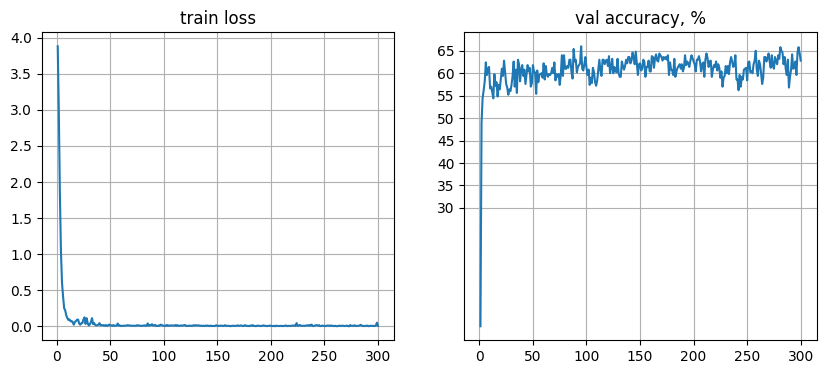

In [131]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
ax.set_title('train loss')
ax.plot(range(1, 300+1), torch.tensor(losses).cpu())
ax.grid(visible=True)

ax = plt.subplot(1, 2, 2)
ax.set_title('val accuracy, %')
ax.plot(range(1, 300+1), torch.tensor(val_accuracies).cpu()*100)
ax.set_yticks(np.arange(30, 66, 5));
ax.grid(visible=True)